# <div align="center">Calculate the Sun's altitude and azimuth at a given time and location on Earth,</div>
### <div align="center">apply atmospheric refraction correction using MERRA-2 reanalysis data,</div>
### <div align="center">plot the Sun's azimuth on a map with projected coordinates</div>

The Python™ code in this Jupyter notebook  
* calculates the Sun's altitude and azimuth at a given time and location on Earth with `Astropy`
* searches for and downloads meteorological parameters from MERRA-2 for the desired location and time using NASA's `earthaccess` tools
* applies a refraction correction to the `Astropy` altitude Sun illumination calculation using MERRA-2 data and `MetPy`
* locates and downloads the CAMBOT L1B natural-color (RGB) GeoTIFF granule/image for the desired time and location from a NASA Distributed Active Archive Center (DAAC) Simple Storage Service (S3 bucket) on the Amazon Web Services (AWS) cloud 
* converts the azimuth angle from geographic to projected coordinates and plots it on a map over the CAMBOT L1B RGB image  

The meteorological parameters used here are reanalyis data products from NASA's **M**odern-**E**ra **R**etrospective Analysis for **R**esearch and **A**pplications, Version **2** (**MERRA-2**) long-term, model-based analyses (https://doi.org/10.5067/VJAFPLI1CSIV). Downloading or streaming MERRA-2 data products requires a free NASA Earthdata Login (EDL) and installation of the `earthaccess` Python™ library. To create a NASA EDL account go to: https://urs.earthdata.nasa.gov/users/new
 
For `MetPy` and `earthaccess` installation instructions see:   
* https://unidata.github.io/MetPy/latest/userguide/installguide.html  
* https://earthaccess.readthedocs.io/en/latest/quick-start/  



In [1]:
VERBOSE = True

# import needed packages & libraries
import os
import numpy as np
import astropy.units as u
from   astropy.coordinates import EarthLocation, AltAz, get_sun, Angle
from   astropy.time import Time
from   pyproj import Transformer
import xarray as xr
from   pathlib import Path
from   urllib.parse import urlparse

try:
    import earthaccess
except ImportError:
    print("To install earthacccess see: https://earthaccess.readthedocs.io/en/latest/quick-start")

try:
    import metpy.calc as mpcalc
    from   metpy.units import units
except ImportError:
    print("To install MetPy see: https://unidata.github.io/MetPy/latest/userguide/installguide.html")

### Calculate sun's altitude and azimuth without atmospheric refraction

In [2]:
# set location and time with Astropy units

lat   =  74.315668 * u.deg    # geographic latitude  in degrees 
lon   = -55.074352 * u.deg    # geographic longitude in degrees 
ele   = 965.1029   * u.m      # elevation  in meters above WGS-84 ellipsoid
t_str = '2019-09-06 13:13:38' # in UTC
t_utc = Time(t_str)           # in UTC

# set location and time
loc = EarthLocation.from_geodetic(lon=lon, lat=lat, height=ele)

# create location and time in the altitude-azimuth (AltAz) horizontal coordinate system with respect to the WGS84 ellipsoid.
altaz = AltAz(obstime=t_utc, location=loc)

# get the Sun's position in AltAz
sun = get_sun(t_utc).transform_to(altaz)

# extract altitude and azimuth angles
altitude = sun.alt
azimuth  = sun.az

In [3]:
# print basic parameters and initial results

if VERBOSE:
    print("Location & Time:\n")
    print(f"\tLongitude   : {int(Angle(lon).dms[0]):+4d}° {abs(int(Angle(lon).dms[1])):2d}′ {abs(Angle(lon).dms[2]):5.2f}″")
    print(f"\tLatitude    : {int(Angle(lat).dms[0]):+4d}° {abs(int(Angle(lat).dms[1])):2d}′ {abs(Angle(lat).dms[2]):5.2f}″")
    print("")
    print(f"\tElevation   : {ele:7.2f}")
    print(f"\tDate & Time :  {t_utc}\n")
    print("Sun illumination:\n")
    print(f"\tSun azimuth : {int(Angle(azimuth).dms[0]):+4d}° {abs(int(Angle(azimuth).dms[1])):2d}′ {abs(Angle(azimuth).dms[2]):5.2f}″")
    print(f"\tSun altitude: {int(Angle(altitude).dms[0]):4d}° {abs(int(Angle(altitude).dms[1])):2d}′ {abs(Angle(altitude).dms[2]):5.2f}″")

Location & Time:

	Longitude   :  -55°  4′ 27.67″
	Latitude    :  +74° 18′ 56.40″

	Elevation   :  965.10 m
	Date & Time :  2019-09-06 13:13:38.000

Sun illumination:

	Sun azimuth : +141° 34′ 20.31″
	Sun altitude:   18° 55′ 10.26″


### Download meteorological parameters from MERRA-2 for atmospheric refraction correction 

In [4]:
#  identify and download MERRA-2 data if it doesn't already exist locally
"""
    Data set ID: M2T1NXSLV (or tavg1_2d_slv_Nx) are hourly, time-averaged, two-dimensional data
    For documentation see: https://doi.org/10.5067/VJAFPLI1CSIV
    
    Variables of interest:
    - QV2M: specific humidity at 2 meters [kg/kg]
    - T2M : temperature at 2 meters [Kelvin]
    - PS  : surface pressure [Pa]
    
    Format: netCDF
    Spatial Coverage: -180.0,-90.0,180.0,90.0
    File Size: approx. 400 MB per daily file
    Spatial resolution: 0.5°×0.625°, temporal resolution: 1 hour
"""

# authenticate. will only prompt for login credentials if .netrc (or _netrc on Windows) is not found or has wrong permissions. 
# to force the use of .netrc if it exists and has proper permissions (chmod 600 ~/.netrc) use:
# auth = earthaccess.login(strategy="netrc")
auth = earthaccess.login()

# identify location of data file and get S3 link on Amazon Web Services (AWS) cloud
results_met = earthaccess.search_data(short_name='M2T1NXSLV', cloud_hosted=True, temporal=(t_str,t_str))

# extract file name
data_links = [granule.data_links(access="direct") for granule in results_met]
s3_url_met = data_links[0][0] # is a nested list

local_data_folder_met = r'../MERRA2'
f_name_short_met = Path(s3_url_met).name
f_name_local_met = Path(local_data_folder_met) / f_name_short_met

# download the file if it does not already exist locally
if os.path.exists(f_name_local_met):
    print(f"✅ File already exists locally: {f_name_short_met} --> Skipping download.")
else:
    print(f"⬇️ Downloading: {f_name_short_met}")
    files = earthaccess.download(results_met, local_path=local_data_folder_met)

✅ File already exists locally: MERRA2_400.tavg1_2d_slv_Nx.20190906.nc4 --> Skipping download.


### Read atmospheric variables from local MERRA-2 file and extract meteorological parameters at desired time and location

In [5]:
# read needed variables from local file
# note: using a "with block" (a.k.a. cxontext manager) ensures the file is properly closed after the block ends, even if an error occurs.

with xr.open_dataset(f_name_local_met) as ds:
    ds_subset = ds[['PS', 'T2M', 'QV2M']]
    
# extract variables at desired location and time using the nearest point 
point = ds_subset.sel(lat=lat.real, lon=lon.real, time=t_str, method='nearest')

In [6]:
# helper function to convert specific humidity from MERRA-2 to relative humidity needed for Astropy using MetPy

def specific_to_relative_humidity_metpy(specific_humidity, temperature, pressure):
    """
    convert specific humidity to relative humidity using MetPy
    
    Parameters:
    - specific_humidity: kg/kg (dimensionless mass ratio)
    - temperature: Kelvin
    - pressure: Pa
    """
    # attach MetPy units
    q = specific_humidity * units('kg/kg')
    T = temperature * units.kelvin
    p = pressure * units.pascal
    
    # calculate relative humidity    
    try:
        rh = mpcalc.relative_humidity_from_specific_humidity(p, T, q, phase='auto')
    except TypeError:
        # fallback for older versions that don't suport "phase" keyword
        rh = mpcalc.relative_humidity_from_specific_humidity(p, T, q)
    
    return rh.magnitude # Astropy needs this to be scaled between 0 and 1, not in percent 

# convert MERRA-2 QV2M (specific humidity) to relative humidity using 2-meter temperature (T2M) and surface pressure (PS)
rel_humidity = specific_to_relative_humidity_metpy(point['QV2M'].values, point['T2M'].values, point['PS'].values)

if VERBOSE:
    print(f"Pressure     : {point['PS'].values/100:7.2f} hPa")
    print(f"Temperature  : {point['T2M'].values - 273.15:7.2f} °C")  # convert from Kelvin to Celsius
    print(f"Rel. humidity: {rel_humidity*100:7.2f} %")

Pressure     :  888.75 hPa
Temperature  :   -6.42 °C
Rel. humidity:   62.81 %


In [7]:
pressure_hPa = point['PS'].values*u.Pa.to(u.hPa)
temp_K       = point['T2M'].values*u.K
temp_C       = temp_K.to(u.deg_C, equivalencies=u.temperature())

wavelength_nm = 532 * u.nm # green ATM lasers
wavelength_um = wavelength_nm.to(u.micron) # convert from nano meters to microns

# add units. not needed for temperature for some reason 
pressure_hPa = pressure_hPa*u.hPa

# create new AltAz frame with atmospheric parameters. convert Pa to hPa and Kelvin to Celsius
altaz_2 = AltAz(obstime=t_utc, location=loc, pressure=pressure_hPa, temperature=temp_C, relative_humidity=rel_humidity, obswl=wavelength_um)

if VERBOSE:
    print(altaz_2)

<AltAz Frame (obstime=2019-09-06 13:13:38.000, location=(990380.47626188, -1418323.6735833, 6119485.68971686) m, pressure=888.7465625 hPa, temperature=-6.424414062499977 deg_C, relative_humidity=0.6280950077314514, obswl=0.532 micron)>


In [8]:
# get the Sun's position in AltAz
sun_2 = get_sun(Time(t_utc)).transform_to(altaz_2)

# extract altitude and azimuth
altitude_2 = sun_2.alt
azimuth_2  = sun_2.az

print("No refraction correction:")
print(f"Altitude: {altitude:7.2f}")
print(f"Azimuth : {azimuth:7.2f}\n")
print("With refraction correction:")
print(f"Altitude: {altitude_2:7.2f}")
print(f"Azimuth : {azimuth_2:7.2f}")

No refraction correction:
Altitude:   18.92 deg
Azimuth :  141.57 deg

With refraction correction:
Altitude:   18.96 deg
Azimuth :  141.57 deg


### Download CAMBOT L1B natural-color (RGB) GeoTIFF image in projected coordinates

In [9]:
# locate a single CAMBOT L1B frame/granule and get S3 link on Amazon Web Services (AWS) cloud

results_cam = earthaccess.search_data( short_name='IOCAM1B', cloud_hosted=True, temporal=(t_str,t_str), count=1 )

data_links = [granule.data_links(access="direct") for granule in results_cam]
s3_url_cam = data_links[0][0] # is a nested list

local_data_folder_cam = r'../CAMBOT_L1B'
f_name_short_cam = f_name_short = Path(s3_url_cam).name
f_name_local_cam = Path(local_data_folder_cam) / f_name_short_cam

# download the file if it does not already exist locally
if os.path.exists(f_name_local_cam):
    print(f"✅ File already exists locally: {f_name_short_cam} --> Skipping download.")
else:
    print(f"⬇️ Downloading: {f_name_short_cam}")
    files = earthaccess.download(results_cam, local_path=local_data_folder_cam)

✅ File already exists locally: IOCAM1B_2019_GR_NASA_20190906-131338.4216.tif --> Skipping download.


### Read relevant data and information from GeoTIFF file and prepare parameters needed for plotting

In [10]:
import rasterio
from   rasterio.plot import reshape_as_image

# import RGB GeoTIFF image and get the parameters needed for plotting and projecting angles and data points
with rasterio.open(f_name_local_cam) as src:
    rgb_image = reshape_as_image(src.read()) 
    crs       = src.crs           # coordinate reference system
    nodata    = src.nodata        # "None" in this case. No data value is 0 for CAMBOT L1B data products (but not set properly as nodata value)    
    bbox      = src.bounds        # returns BoundingBox object: left, bottom, right, top
    epsg_code = src.crs.to_epsg() # integer code

if nodata is None:
    mask = np.all(rgb_image == [0, 0, 0], axis=-1)
    # replace all nodata pixels with white
    rgb_image[mask] = [255, 255, 255]

extent_m  = [bbox.left, bbox.right, bbox.bottom, bbox.top]
extent_km = [bbox.left/1000, bbox.right/1000, bbox.bottom/1000, bbox.top/1000]

In [11]:
# helper function for image enhancement

from PIL import Image
from PIL import ImageEnhance

# rgb_image is in shape (height, width, 3)
rgb_image_uint8 = rgb_image.astype(np.uint8)  # make sure image is in 8-bit
pil_img = Image.fromarray(rgb_image_uint8)

# brightness
brightness_enhancer = ImageEnhance.Brightness(pil_img)
bright_img = brightness_enhancer.enhance(1.2)

# contrast
contrast_enhancer = ImageEnhance.Contrast(bright_img)
contrast_img = contrast_enhancer.enhance(1.1)

# sharpness
sharpness_enhancer = ImageEnhance.Sharpness(contrast_img)
rgb_image_adj = sharpness_enhancer.enhance(1.5)  # Double sharpness

### Set up transformations for forward and inverse map projections from geographic to projected CRS

In [12]:
from pyproj import Transformer

# create a transformer object for forward map projection from geo to xy
transformer_geo_to_xy = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code:d}", always_xy=True)
# create a transformer object for inverse map projection from xy to geo
transformer_xy_to_geo = Transformer.from_crs(f"EPSG:{epsg_code:d}", "EPSG:4326", always_xy=True)

if VERBOSE:
    print(f"Projected CRS used: EPSG:{epsg_code}")

Projected CRS used: EPSG:3413


### Calculate angle/azimuth of true north and sun illumination in projected coordinates

In [13]:
from pyproj import Geod

# define reference ellipsoid to use
geod = Geod(ellps="WGS84")

# determine x and y offsets and length based on GeoTIFF extent
dx_x = bbox.right - bbox.left
dx_x = np.ceil(dx_x)
# print(dx_x) # 500 m here
x_offset = dx_x * 0.025 

# true north arrow starting point x and y
xns, yns = bbox.left + 2.5*x_offset, bbox.bottom + x_offset
lon_n_s, lat_n_s = transformer_xy_to_geo.transform(xns, yns)
# calculate endpoint in lat lon
lon_n_e, lat_n_e, _ = geod.fwd(lon_n_s, lat_n_s, 0.0, dx_x*0.08)
# calculate endpoint in x y
xne, yne = transformer_geo_to_xy.transform(lon_n_e, lat_n_e)
angle_rad_n = np.arctan2(yne - yns, xne - xns)
angle_deg_n = np.degrees(angle_rad_n)

# sun illumination arrow starting point x and y
xss, yss = -298890, -1683000
lon_s_s, lat_s_s = transformer_xy_to_geo.transform(xss, yss)
# calculate endpoint in lat lon
lon_s_e, lat_s_e, _ = geod.fwd(lon_s_s, lat_s_s, azimuth, dx_x*0.125)
# calculate endpoint in x y
xse, yse = transformer_geo_to_xy.transform(lon_s_e, lat_s_e)
angle_rad_s = np.arctan2(yse - yss, xse - xss) 
angle_deg_s = np.degrees(angle_rad_s)

### Plot GeoTIFF RGB image in projected coordinates with sun illumination and true north arrows 

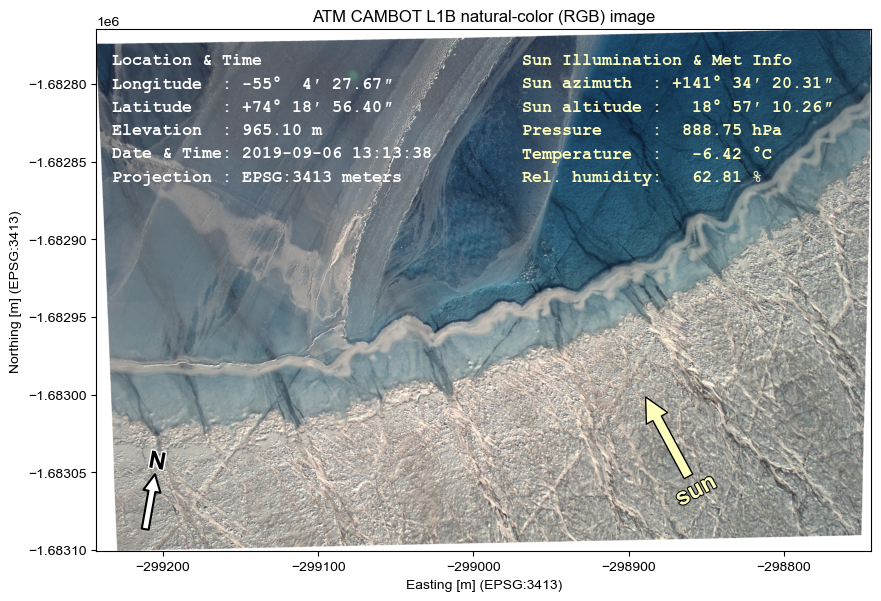

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as fx

# set font to Arial for all objects
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_image_adj, extent=extent_m, origin='upper')
ax.set_xlabel(f"Easting [m] (EPSG:{epsg_code:d})")
ax.set_ylabel(f"Northing [m] (EPSG:{epsg_code:d})")
ax.set_title("ATM CAMBOT L1B natural-color (RGB) image");

# north arrow and label
ax.annotate("",xy = (xne, yne), xycoords='data',
    xytext=(xns, yns), textcoords='data',size=25, va="center", ha="center",
    arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.0",fc='w',lw = 1.5,ec = "black"));
north_text = ax.text(xne + 6.0 / np.tan(angle_rad_n), yne + 6.0, "N", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold',rotation= angle_deg_n-90, rotation_mode='anchor', ha='center', va='center', color = 'k');
north_text.set_path_effects([fx.Stroke(linewidth=2.0,foreground='1.0'),fx.Normal()])

# sun illumination arrow and label
yucca_yellow = (255/256, 255/256, 190/256)
ax.annotate("",xy = (xss, yss), xycoords='data',
    xytext=(xse, yse), textcoords='data',size=35, va="center", ha="center",
    arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.0",fc=yucca_yellow,lw = 1.0,ec = "black"));
sun_text = ax.text(xse - 7.5 / np.tan(angle_rad_s), yse - 7.5, "sun", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold',rotation= angle_deg_s+90, rotation_mode='anchor', ha='center', va='center', color = yucca_yellow);
sun_text.set_path_effects([fx.Stroke(linewidth=1.5,foreground='0.0'),fx.Normal()]);

# location info in upper left
ax.text(bbox.left + 10, bbox.top - 20, "Location & Time", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');
ax.text(bbox.left + 10, bbox.top - 35, f"Longitude  : {int(Angle(lon).dms[0]):+3d}° {abs(int(Angle(lon).dms[1])):2d}′ {abs(Angle(lon).dms[2]):5.2f}″", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');
ax.text(bbox.left + 10, bbox.top - 50, f"Latitude   : {int(Angle(lat).dms[0]):+3d}° {abs(int(Angle(lat).dms[1])):2d}′ {abs(Angle(lat).dms[2]):5.2f}″", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');
ax.text(bbox.left + 10, bbox.top - 65, f"Elevation  : {ele:6.2f}", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');
ax.text(bbox.left + 10, bbox.top - 80, f"Date & Time: {t_str:s}" , fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');
ax.text(bbox.left + 10, bbox.top - 95, f"Projection : EPSG:{epsg_code:d} meters" , fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = 'w');


# sun illumination and met info in upper right
ax.text(bbox.right - 225, bbox.top - 20, "Sun Illumination & Met Info", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);
ax.text(bbox.right - 225, bbox.top - 35, f"Sun azimuth  : {int(Angle(azimuth).dms[0]):+4d}° {abs(int(Angle(azimuth_2).dms[1])):2d}′ {abs(Angle(azimuth).dms[2]):5.2f}″", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);
ax.text(bbox.right - 225, bbox.top - 50, f"Sun altitude : {int(Angle(altitude).dms[0]):4d}° {abs(int(Angle(altitude_2).dms[1])):2d}′ {abs(Angle(altitude).dms[2]):5.2f}″", fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);
ax.text(bbox.right - 225, bbox.top - 65, f"Pressure     : {point['PS'].values/100:7.2f} hPa" , fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);
ax.text(bbox.right - 225, bbox.top - 80, f"Temperature  : {point['T2M'].values - 273.15:7.2f} °C" , fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);
ax.text(bbox.right - 225, bbox.top - 95, f"Rel. humidity: {rel_humidity*100:7.2f} %" , fontsize = 'large',font = 'Courier New',fontweight = 'bold', ha='left', va='center', color = yucca_yellow);

## References  

Global Modeling and Assimilation Office (GMAO) (2015), MERRA-2 tavg1_2d_slv_Nx: 2d, 1-Hourly, Time-Averaged, Single-Level, Assimilation, Single-Level Diagnostics (V5.12.4), [Data Set]. Greenbelt, Maryland USA. Goddard Earth Sciences Data and Information Services Center (GES DISC), Date accessed: August 14, 2025, https://doi.org/10.5067/VJAFPLI1CSIV  

Studinger, M. & Harbeck, J. (2019). IceBridge CAMBOT L1B Geolocated Images. (IOCAM1B, Version 2). [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center (NSIDC). NASA Distributed Active Archive Center (DAAC). Date accessed: August 14, 2025, https://doi.org/10.5067/B0HL940D452L  